# Running a hydrological model over a watershed defined by a shapefile

This notebook shows how to run Raven over a user-defined watershed. The watershed contour is provided by a shapefile, which we use to subset meteorological data and to extract watershed physiographic properties. The meteorological data is spatially averaged, then fed to the Raven hydrological model to simulate streamflow. 

In [1]:
from birdy import WPSClient

from example_data import TESTDATA
import datetime as dt
from urllib.request import urlretrieve
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import os
import json
import netCDF4 as nc
import salem
from zipfile import ZipFile
import glob
import tempfile
from pathlib import Path

# Set environment variable RAVEN_WPS_URL to "http://localhost:9099" to run on the default local server
url = os.environ.get("RAVEN_WPS_URL", "https://pavics.ouranos.ca/twitcher/ows/proxy/raven/wps")
wps = WPSClient(url)

# Temporary directory to store meteorological data
tmp = Path(tempfile.mkdtemp())

In [15]:
# SETUP THE RUN PARAMETERS. The data will be extracted to cover the simulation period

simulationStart=dt.datetime(2001,1,1,0,0,0)
simulationEnd=dt.datetime(2002,12,31,0,0,0)
UTCoffset_hours = -6 # for UTC delta

# The shapefile of the catchment. All files (.shp, .shx, etc.) must be zipped into one file.
vec = TESTDATA['watershed_vector']

# Choose a dataset to use. We have 'NRCAN' and 'ERA5' for now. 
# NRCAN is only available in Canada, while ERA5 is global.
dataset = 'ERA5' 

# Choose a hydrological model to use. We have 'HMETS', 'GR4JCN','MOHYSE' and 'HBVEC'.
hydromodel = 'HBVEC'

In [16]:
# We will first need to process the catchment boundaries from the zipped shapefile. 
ZipFile(vec,'r').extractall(tmp)
shp = list(tmp.glob("*.shp"))[0]
shdf=salem.read_shapefile(shp)
shdf.crs=salem.wgs84 # This is needed in certain cases!

lon_min=shdf['min_x'][0]
lon_max=shdf['max_x'][0]
lat_min=shdf['min_y'][0]
lat_max=shdf['max_y'][0]

In [17]:
# From the shapefile, call the PAVICS-Hydro service to extract properties such as centroid lat/long, elevation and area.
resp = wps.shape_properties(shape=str(vec))
[properties, ]=resp.get(asobj=True)
prop = properties[0]
basin_area = prop['area']/1000000.0
basin_longitude = prop['centroid'][0]
basin_latitude = prop['centroid'][1]

# This uses the HydroSheds DEM
resp = wps.terrain_analysis(shape=str(vec), select_all_touching=True, projected_crs=3978)
properties, dem = resp.get(asobj=True)
basin_elevation=properties[0]['elevation']

print("Area: ", basin_area)
print("Elevation: ", basin_elevation)
print("Longitude: ", basin_longitude)
print("Latitude: ", basin_latitude)

Area:  44877.1880529685
Elevation:  404.70766683028666
Longitude:  -72.69128332186322
Latitude:  49.50119363123194


In [18]:
if dataset=='NRCAN':
    # Define the path to the netcdf file and write to disk (the basin averaged data)
    tsfile= tmp / 'NRCAN_ts.nc'
    
    if not tsfile.exists():
        # Path to unified NetCDF ML dataset file on the THREDDS server (OPeNDAP link)
        NRCAN_url='https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/1-Datasets/gridded_obs/nrcan_v2.ncml'

        #Open the dataset file and slice the desired lat/lon (+1°Buffer) and limit to the time simulation duration
        ds=xr.open_dataset(NRCAN_url).sel(lat=slice(lat_max+1,lat_min-1), lon=slice(lon_min-1,lon_max+1), time=slice(simulationStart, simulationEnd))

        # Now apply the mask of the basin contour and average the values to get a single time series 
        sub = ds.salem.roi(shape=shdf).mean(dim={'lat','lon'}, keep_attrs=True)

        sub.to_netcdf(tsfile)

        # Raven expects to have 00:00:00 at the end of the time vector, so let's add that
        D = nc.Dataset(tsfile, mode="a")
        D.variables["time"].units += " 00:00:00"
        D.close()
    
    # Prepare the linear transform parameters for the hydrological model run.
    nc_transforms = json.dumps({'tasmax': {'linear_transform': (1.0, -273.15)},'tasmin': {'linear_transform': (1.0, -273.15)},'pr': {'linear_transform': (86400.0, 0.0)}})

In [19]:
if dataset=='ERA5':
    tsfile=tmp / 'ERA5_ts.nc'
    
    if not tsfile.exists():    
        ERA5_url='https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/1-Datasets/reanalyses/era5.ncml'
        ds=xr.open_dataset(ERA5_url).sel(latitude=slice(lat_max+1,lat_min-1), longitude=slice(lon_min+360-1,lon_max+360+1),time=slice(simulationStart-dt.timedelta(days=1),simulationEnd+dt.timedelta(days=1)))

        # Special treatment for ERA5 in North America: ECMWF stores ERA5 longitude in 0:360 format rather than -180:180. We need to reassign the longitudes here
        ds=ds.assign_coords({'longitude':ds['longitude'].values[:]-360})
        sub = ds.salem.roi(shape=shdf).mean(dim={'latitude','longitude'},keep_attrs=True)

        # Define the path to the netcdf file and write to disk (the basin averaged data)

        sub.to_netcdf(tsfile)

        # Add precision on time format for Raven
        D = nc.Dataset(tsfile, mode="a")
        D.variables["time"].units += " 00:00:00"
        D.close()
    
    #Perform the linear transform and time shift
    nc_transforms=json.dumps({'tas': {'linear_transform': (1.0, -273.15), 'time_shift': UTCoffset_hours/24}, 'pr': {'linear_transform': (1000, 0.0), 'time_shift': UTCoffset_hours/24}})     
   

In [20]:
# Model configuration parameters
config = dict(
    start_date=simulationStart,
    end_date=simulationEnd,
    area=basin_area,
    elevation=basin_elevation,
    latitude=basin_latitude,
    longitude=basin_longitude,
    run_name='test_' + dataset + '_' + hydromodel,
    nc_spec= nc_transforms
)


In [41]:
# Here is where the magic happens, and the RAVEN modeling framework parses the information that we give it
# to run the hydrological model that we chose with the dataset that we chose.

hydromodel="HMETS"

# Here we provide a set of hydrological model parameters by default, but these can be adjusted, modified or calibrated later.
if hydromodel=='HMETS':
    params = '9.5019, 0.2774, 6.3942, 0.6884, 1.2875, 5.4134, 2.3641, 0.0973, 0.0464, 0.1998, 0.0222, -1.0919,2.6851, 0.3740, 1.0000, 0.4739, 0.0114, 0.0243, 0.0069, 310.7211, 916.1947'
    resp = wps.raven_hmets(ts=str(tsfile), params=params, rain_snow_fraction='RAINSNOW_DINGMAN', **config,)
    
elif hydromodel=='GR4JCN':
    params = '0.529, -3.396, 407.29, 1.072, 16.9, 0.947'
    resp = wps.raven_gr4j_cemaneige(ts=str(tsfile), params = params, **config)
    
elif hydromodel=='MOHYSE':
    params = '1.00, 0.0468, 4.2952, 2.6580, 0.4038, 0.0621, 0.0273, 0.0453'
    hrus = '0.9039, 5.6179775' # MOHYSE has a particular setup that requires parameters for HRUs.
    resp = wps.raven_mohyse(ts=str(tsfile), params = params, hrus=hrus, rain_snow_fraction='RAINSNOW_DINGMAN', **config)  
    
elif hydromodel=='HBVEC':
    params = '0.05984519, 4.072232, 2.001574, 0.03473693, 0.09985144, 0.5060520, 3.438486, 38.32455, 0.4606565, 0.06303738, 2.277781, 4.873686, 0.5718813, 0.04505643, 0.877607, 18.94145, 2.036937, 0.4452843, 0.6771759, 1.141608, 1.024278'
    resp = wps.raven_hbv_ec(ts=str(tsfile), evaporation="PET_OUDIN", ow_evaporation="PET_OUDIN", params=params, **config)
    

In [42]:
# The model has run! We can get the response.
# With `asobj` set to False, only the reference to the output is returned in the response. 
# Setting `asobj` to True will retrieve the actual files and copy them locally. 
[hydrograph, storage, solution, diagnostics, rv] = resp.get(asobj=True)

Since we requested output objects, we can simply access the output objects. The dianostics is just a CSV file: 

In [43]:
print(diagnostics)

:TimeStamp 2002-12-31 00:00:00.00
:HRUStateVariableTable
  :Attributes,SURFACE_WATER,ATMOSPHERE,ATMOS_PRECIP,PONDED_WATER,SOIL[0],SOIL[1],SNOW,SNOW_LIQ,CUM_SNOWMELT,CONVOLUTION[0],CONVOLUTION[1],AET,CONV_STOR[0],CONV_STOR[1],CONV_STOR[2],CONV_STOR[3],CONV_STOR[4],CONV_STOR[5],CONV_STOR[6],CONV_STOR[7],CONV_STOR[8],CONV_STOR[9],CONV_STOR[10],CONV_STOR[11],CONV_STOR[12],CONV_STOR[13],CONV_STOR[14],CONV_STOR[15],CONV_STOR[16],CONV_STOR[17],CONV_STOR[18],CONV_STOR[19],CONV_STOR[20],CONV_STOR[21],CONV_STOR[22],CONV_STOR[23],CONV_STOR[24],CONV_STOR[25],CONV_STOR[26],CONV_STOR[27],CONV_STOR[28],CONV_STOR[29],CONV_STOR[30],CONV_STOR[31],CONV_STOR[32],CONV_STOR[33],CONV_STOR[34],CONV_STOR[35],CONV_STOR[36],CONV_STOR[37],CONV_STOR[38],CONV_STOR[39],CONV_STOR[40],CONV_STOR[41],CONV_STOR[42],CONV_STOR[43],CONV_STOR[44],CONV_STOR[45],CONV_STOR[46],CONV_STOR[47],CONV_STOR[48],CONV_STOR[49],CONV_STOR[50],CONV_STOR[51],CONV_STOR[52],CONV_STOR[53],CONV_STOR[54],CONV_STOR[55],CONV_STOR[56],CONV_STOR[57]

The `hydrograph` and `storage` outputs are netCDF files storing the time series. These files are opened by default using `xarray`, which provides convenient and powerful time series analysis and plotting tools. 

In [44]:
hydrograph.q_sim

<xarray.DataArray 'q_sim' (time: 730, nbasins: 1)>
array([[   0.      ],
       [1804.451682],
       [3571.474031],
       ...,
       [  43.526599],
       [  42.919859],
       [  42.319753]])
Coordinates:
  * time        (time) datetime64[ns] 2001-01-01 2001-01-02 ... 2002-12-31
    basin_name  (nbasins) object ...
Dimensions without coordinates: nbasins
Attributes:
    units:      m**3 s**-1
    long_name:  Simulated outflows

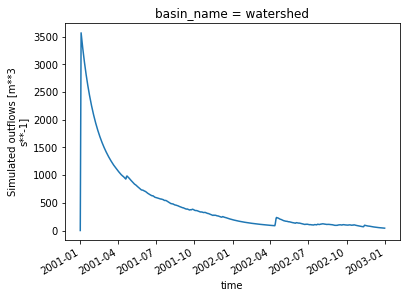

In [45]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

hydrograph.q_sim.plot()

In [35]:
print("Max: ", hydrograph.q_sim.max())
print("Mean: ", hydrograph.q_sim.mean())
print("Monthly means: ", hydrograph.q_sim.groupby(hydrograph.time.dt.month).mean(dim='time'))

Max:  <xarray.DataArray 'q_sim' ()>
array(15.44205159)
Mean:  <xarray.DataArray 'q_sim' ()>
array(0.36020714)
Monthly means:  <xarray.DataArray 'q_sim' (month: 12, nbasins: 1)>
array([[3.61898654],
       [0.60252831],
       [0.07794292],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ]])
Coordinates:
    basin_name  (nbasins) object ...
  * month       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nbasins
